The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. 
* This prediction is being done at the time of posting so you can only use data available to you at that time. 
* The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). 
* The data spans Jan 1, 2012 to Dec 31, 2013. 
* You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). 
* The training sets should be everything from 1/1/12 to the beginning of the test set.

In [1]:
# basic dependencies
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn import preprocessing

# my own library of useful functions
import utils
import exploration as exp
import pipeline as pipe

In [2]:
projraw = utils.read_data('projects_2012_2013', 'csv')

In [3]:
projraw.head()

projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0        -87.673257        Chicago           IL        urban   
1       -119.296596        Ventura           CA        urban   
2       -118.257834    Los Angeles           CA        urban   
3        -73.988217       Brooklyn           NY        urban   
4        -73.205635  Central Islip           NY     suburban   

                school_district       ...       secondary_focus_subject  \
0         Pershing Elem Network       ...                   Visual Arts   
1  Ventura Unif School District       ...          Literature & Writing   
2     Los Angeles Unif Sch Dist       ...               Social Sciences   
3      New York City Dept Of Ed       ...                           NaN   
4   Central Islip Union Free SD       ...          Literature & Writing   

  secondary_focus_area resource_type    poverty_level    grade_level  \
0     Music & The Arts      Supplies  highest poverty  Grades PreK-2   
1  Literacy & Language         Books  highest poverty     Grades 3-5   
2     History & Civics    Technology     high poverty     Grades 3-5   
3                  NaN         Books     high poverty  Grades PreK-2   
4  Literacy & Language    Technology     high poverty  Grades PreK-2   

  total_price_including_optional_support students_reached  \
0                                1498.61             31.0   
1                                 282.47             28.0   
2                                1012.38             56.0   
3                                 175.33             23.0   
4                                3591.11            150.0   

  eligible_double_your_impact_match date_posted datefullyfunded  
0                                 f     4/14/13          5/2/13  
1                                 t      4/7/12         4/18/12  
2                                 f     1/30/12         4/15/12  
3                                 f    10/11/12         12/5/12  
4                                 f      1/8/13         3/25/13  

[5 rows x 26 columns]

In [4]:
utils.find_cols_with_missing(projraw)

school_ncesid               9233
school_metro               15224
school_district              172
primary_focus_subject         15
primary_focus_area            15
secondary_focus_subject    40556
secondary_focus_area       40556
resource_type                 17
grade_level                    3
students_reached              59
dtype: int64

In [5]:
projraw.info()
# results of this make me want to not include secondary focus subject or area as a feature.
# Create boolean features for is_subject... etc. Then I can include nans. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 26 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

Here's what I'm going to do to this dataframe:
* convert date columns to dates
* convert t/f columns to actual booleans
* take the categorical variables and convert them to binary
* what should I normalize??? probably price, students reached

In [6]:
# convert categorical variables to binary
categorical_list = ['school_metro',
                    'primary_focus_subject',
                    'primary_focus_area',
                    'secondary_focus_subject',
                    'secondary_focus_area', 
                    'resource_type', 
                    'poverty_level',
                    'grade_level']
proj = utils.make_cat_dummy(projraw, categorical_list)

# create major city dummy for biggest cities
big_cities = ['Los Angeles', 'Chicago', 'Houston', 'Brooklyn', 'Bronx', 'New York']
proj['in_big_city'] = np.where(proj['school_city'].isin(big_cities), 1, 0)

# create dummies for female teacher and teacher with doctorate
proj['teacher_is_female'] = np.where(proj['teacher_prefix'].isin(['Mrs.', 'Ms.']), True, False)
proj['teacher_is_dr'] = np.where(proj['teacher_prefix'] == 'Dr.', True, False)

# replace string true/false with boolean values
proj = utils.convert_to_boolean(proj, ['school_charter',
                                       'school_magnet',
                                      'eligible_double_your_impact_match'], 't', 'f')

# convert date fields and compute whether project is funded within 60 days
proj['date_posted'] = pd.to_datetime(proj.date_posted) 
proj['datefullyfunded'] = pd.to_datetime(proj.datefullyfunded)
proj['funded'] = np.where(proj.datefullyfunded - proj.date_posted < datetime.timedelta(days=60), 1, 0)

# normalize project price 
proj['total_price_norm'] = preprocessing.scale(proj['total_price_including_optional_support'].astype('float64'))

In [7]:
proj.corr()['funded']

school_ncesid                                 -0.013768
school_latitude                                0.063793
school_longitude                               0.003058
school_charter                                 0.016644
school_magnet                                  0.016915
total_price_including_optional_support        -0.085499
students_reached                              -0.012292
eligible_double_your_impact_match              0.099572
school_metro_rural                            -0.050992
school_metro_suburban                         -0.014630
school_metro_urban                             0.060293
school_metro_nan                              -0.022656
primary_focus_subject_Applied Sciences         0.014951
primary_focus_subject_Character Education      0.009040
primary_focus_subject_Civics & Government      0.002517
primary_focus_subject_College & Career Prep   -0.019132
primary_focus_subject_Community Service       -0.000556
primary_focus_subject_ESL                     -0

In [8]:
not_feature_cols = ['teacher_acctid',
                    'schoolid',
                    'school_ncesid',
                    'school_latitude', 
                    'school_longitude',
                    'school_district',
                    'school_county',
                    'school_city',
                    'projectid',
                    'teacher_prefix',
                    'date_posted',
                    'datefullyfunded',
                    'funded',
                    'interval',
                    'bins',
                    'students_reached', 
                    'total_price_including_optional_support',
                   'eligible_double_your_impact_match',
                   'total_price_norm',
                   'school_state']
features = list(set(proj.columns).difference(not_feature_cols))
features

['secondary_focus_subject_Visual Arts',
 'primary_focus_subject_Literature & Writing',
 'secondary_focus_subject_Health & Life Science',
 'secondary_focus_subject_College & Career Prep',
 'primary_focus_subject_Applied Sciences',
 'primary_focus_subject_Health & Wellness',
 'secondary_focus_area_Health & Sports',
 'grade_level_Grades PreK-2',
 'primary_focus_subject_ESL',
 'primary_focus_subject_Other',
 'secondary_focus_subject_Music',
 'secondary_focus_subject_Civics & Government',
 'school_metro_nan',
 'secondary_focus_subject_Social Sciences',
 'resource_type_Trips',
 'grade_level_Grades 6-8',
 'secondary_focus_subject_Community Service',
 'primary_focus_subject_Health & Life Science',
 'secondary_focus_subject_Literature & Writing',
 'resource_type_Other',
 'primary_focus_subject_Early Development',
 'primary_focus_area_Health & Sports',
 'poverty_level_high poverty',
 'primary_focus_subject_Foreign Languages',
 'primary_focus_area_nan',
 'secondary_focus_subject_Parent Involvemen

### Create training and test sets: expanding-window temporal cross-validation

In [9]:
lag_time = datetime.timedelta(days=60)
proj = pipe.create_sliding_window_sets(proj, 'date_posted', features, 'funded', 26, lag_time)

In [10]:
intervals = list(proj.interval.unique())
k = len(intervals) - 1

x_train0 = proj[features].loc[proj.interval == intervals[1]]
y_train0 = proj['funded'].loc[proj.interval == intervals[1]]
x_test0 = proj[features].loc[proj.interval == intervals[2]]
y_test0 = proj['funded'].loc[proj.interval == intervals[2]]

y_test0.sum()/y_test0.count()

0.7432083589428395

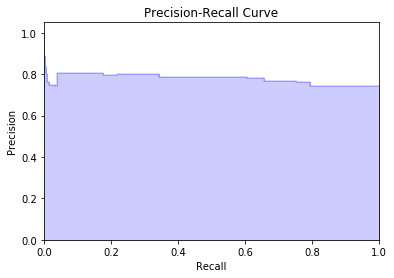

In [11]:
classifier = pipe.build_classifier('DecisionTree', x_train0, y_train0, max_depth = 5)
# num_obvs = y_test0.count()
# pred_scores = pd.DataFrame(classifier.predict_proba(x_test0)[:,1])
# pred_scores['rank'] = pred_scores.rank()

# rank_list = [p * num_obvs for p in pipe.PERCENTILES]
# calc_threshold = lambda x,y: 0 if x < y else 1 


# for t in threshold_list:
#     predicted_test = np.array( [calc_threshold(rank, t) for rank in pred_scores['rank']] )
#     pd.DataFrame(predicted_test).hist()
pipe.draw_precision_recall_curve(classifier, x_test0, y_test0)

In [12]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import precision_recall_curve 

def compute_eval_stats(classifier, y_data, pred_scores, threshold):
    ''' Takes: classifier object, truex target data, predicted scores, 
                prediction score threshold
        Returns: accuracy, precision, recall of predictions of classifier on x for y
    '''

    predicted_test = np.where(pred_scores > threshold, 1, 0)
    
    print(y_data.head())
    print(predicted_test[1:10])
    print(pred_scores[1:10])

    stats = [accuracy(y_data, predicted_test),
            precision(y_data, predicted_test),
            recall(y_data, predicted_test),
            f1(y_data, predicted_test),
            roc(y_data, predicted_test)]

    return stats

from sklearn.svm import LinearSVC

def compute_pred_scores(classifier, x_data, rank = False):
    ''' Takes a classifier and feature data and generates predicted scores.
        If rank is True, then it returns rankings intead of scores.
    '''

    if type(classifier) == LinearSVC:
        pred_scores = classifier.decision_function(x_data)
    else:
        pred_scores = classifier.predict_proba(x_data)[:,1]

    print(pred_scores[1:10])
    if rank:
        return pd.DataFrame(pred_scores).rank()[0]
    else:
        return pred_scores


In [13]:
# scores = compute_pred_scores(classifier, x_test0, rank=True)
# compute_eval_stats(classifier, y_test0, scores, 16000)

In [19]:
test_params = pipe.CLASSIFIERS['DecisionTree']
pipe.test_classifier_parameters('DecisionTree', x_train0, y_train0, x_test0, y_test0, test_params)

scores are: 
[0.72216998 0.63065833 0.72216998 0.72216998 0.63065833 0.72216998
 0.72216998 0.72216998 0.72216998]
ranks are
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
29286.0
3     1
5     0
9 

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda

scores are: 
[0.74664502 0.6209158  0.61862528 0.74664502 0.6209158  0.74664502
 0.74664502 0.74664502 0.70198782]
ranks are
1    26448.5
2     7118.5
3     1067.0
4    26448.5
5     7118.5
6    26448.5
7    26448.5
8    26448.5
9    16204.0
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26448.5
2     7118.5
3     1067.0
4    26448.5
5     7118.5
6    26448.5
7    26448.5
8    26448.5
9    16204.0
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26448.5
2     7118.5
3     1067.0
4    26448.5
5     7118.5
6    26448.5
7    26448.5
8    26448.5
9    16204.0
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26448.5
2     7118.5
3     1067.0
4    26448.5
5     7118.5
6    26448.5
7    26448.5
8    26448.5
9    16204.0
Name: 0, dtype: float64
29286.0
3     1
5     0
9 

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


scores are: 
[0.69422777 0.70909091 0.67455621 0.74390244 0.39130435 0.780135
 0.74054054 0.7654321  0.62181818]
ranks are
1    15668.0
2    16699.0
3    12566.0
4    21567.0
5     2024.0
6    23844.5
7    21238.5
8    22758.5
9    10136.0
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    15668.0
2    16699.0
3    12566.0
4    21567.0
5     2024.0
6    23844.5
7    21238.5
8    22758.5
9    10136.0
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    15668.0
2    16699.0
3    12566.0
4    21567.0
5     2024.0
6    23844.5
7    21238.5
8    22758.5
9    10136.0
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    15668.0
2    16699.0
3    12566.0
4    21567.0
5     2024.0
6    23844.5
7    21238.5
8    22758.5
9    10136.0
Name: 0, dtype: float64
29286.0
3     1
5     0
9   

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda

scores are: 
[0.72216998 0.63065833 0.72216998 0.72216998 0.63065833 0.72216998
 0.72216998 0.72216998 0.72216998]
ranks are
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    21907.5
2     5637.5
3    21907.5
4    21907.5
5     5637.5
6    21907.5
7    21907.5
8    21907.5
9    21907.5
Name: 0, dtype: float64
29286.0
3     1
5     0
9 

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda

scores are: 
[0.74664502 0.6209158  0.68109806 0.74664502 0.6209158  0.74664502
 0.74664502 0.74664502 0.68109806]
ranks are
1    26012.5
2     4989.5
3    14921.5
4    26012.5
5     4989.5
6    26012.5
7    26012.5
8    26012.5
9    14921.5
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26012.5
2     4989.5
3    14921.5
4    26012.5
5     4989.5
6    26012.5
7    26012.5
8    26012.5
9    14921.5
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26012.5
2     4989.5
3    14921.5
4    26012.5
5     4989.5
6    26012.5
7    26012.5
8    26012.5
9    14921.5
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    26012.5
2     4989.5
3    14921.5
4    26012.5
5     4989.5
6    26012.5
7    26012.5
8    26012.5
9    14921.5
Name: 0, dtype: float64
29286.0
3     1
5     0
9 

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


scores are: 
[0.65889213 0.70909091 0.66666667 0.77777778 0.3125     0.77492877
 0.71040724 0.75072464 0.60480349]
ranks are
1    12349.5
2    17119.5
3    12831.5
4    25202.0
5     1309.5
6    24216.5
7    17317.5
8    23110.0
9     9058.5
Name: 0, dtype: float64
32214.6
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    12349.5
2    17119.5
3    12831.5
4    25202.0
5     1309.5
6    24216.5
7    17317.5
8    23110.0
9     9058.5
Name: 0, dtype: float64
31889.2
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    12349.5
2    17119.5
3    12831.5
4    25202.0
5     1309.5
6    24216.5
7    17317.5
8    23110.0
9     9058.5
Name: 0, dtype: float64
30913.0
3     1
5     0
9     1
15    1
19    1
Name: funded, dtype: int64
[0 0 0 0 0 0 0 0 0]
1    12349.5
2    17119.5
3    12831.5
4    25202.0
5     1309.5
6    24216.5
7    17317.5
8    23110.0
9     9058.5
Name: 0, dtype: float64
29286.0
3     1
5     0
9 

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold  Accuracy  Precision    Recall        F1  AUC_ROC Score  \
0     32214.6  0.256792   0.000000  0.000000  0.000000       0.500000   
1     31889.2  0.256792   0.000000  0.000000  0.000000       0.500000   
2     30913.0  0.256792   0.000000  0.000000  0.000000       0.500000   
3     29286.0  0.256792   0.000000  0.000000  0.000000       0.500000   
4     26032.0  0.256792   0.000000  0.000000  0.000000       0.500000   
5     22778.0  0.256792   0.000000  0.000000  0.000000       0.500000   
6     16270.0  0.617025   0.775604  0.682021  0.725809       0.555467   
0     32214.6  0.259312   0.927083  0.003680  0.007331       0.501421   
1     31889.2  0.267302   0.755224  0.020923  0.040718       0.500648   
2     30913.0  0.267302   0.755224  0.020923  0.040718       0.500648   
3     29286.0  0.267302   0.755224  0.020923  0.040718       0.500648   
4     26032.0  0.469822   0.801025  0.381368  0.516724       0.553597   
5     22778.0  0.469822   0.801025  0.381368  0.516724       0.553597   
6     16270.0  0.479963   0.796699  0.403159  0.535391       0.552704   
0     32214.6  0.261739   0.801498  0.008849  0.017504       0.501253   
1     31889.2  0.265058   0.764244  0.016085  0.031507       0.500862   
2     30913.0  0.274800   0.741749  0.037173  0.070799       0.499858   
3     29286.0  0.354579   0.805374  0.173503  0.285500       0.526077   
4     26032.0  0.377628   0.796352  0.218450  0.342852       0.528385   
5     22778.0  0.447880   0.798942  0.343574  0.480511       0.546667   
6     16270.0  0.551321   0.783819  0.547221  0.644492       0.555205   
0     32214.6  0.256792   0.000000  0.000000  0.000000       0.500000   
1     31889.2  0.269422   0.792319  0.023032  0.044762       0.502780   
2     30913.0  0.285341   0.783405  0.053093  0.099446       0.505304   
3     29286.0  0.309773   0.780416  0.099198  0.176022       0.509209   
4     26032.0  0.381100   0.795040  0.225356  0.351171       0.528606   
5     22778.0  0.436386   0.800370  0.321948  0.459188       0.544770   
6     16270.0  0.540996   0.786139  0.525306  0.629784       0.555855   
0     32214.6  0.256792   0.000000  0.000000  0.000000       0.500000   
1     31889.2  0.256792   0.000000  0.000000  0.000000       0.500000   
..        ...       ...        ...       ...       ...            ...   
5     22778.0  0.256792   0.000000  0.000000  0.000000       0.500000   
6     16270.0  0.617025   0.775604  0.682021  0.725809       0.555467   
0     32214.6  0.265581   0.768797  0.016912  0.033096       0.501096   
1     31889.2  0.265581   0.768797  0.016912  0.033096       0.501096   
2     30913.0  0.273571   0.746835  0.034155  0.065322       0.500323   
3     29286.0  0.273571   0.746835  0.034155  0.065322       0.500323   
4     26032.0  0.273571   0.746835  0.034155  0.065322       0.500323   
5     22778.0  0.476091   0.798577  0.394600  0.528201       0.553272   
6     16270.0  0.486232   0.794540  0.416391  0.546421       0.552379   
0     32214.6  0.261432   0.821277  0.007980  0.015807       0.501477   
1     31889.2  0.267271   0.763524  0.020427  0.039789       0.501058   
2     30913.0  0.276706   0.743976  0.040853  0.077454       0.500082   
3     29286.0  0.276706   0.743976  0.040853  0.077454       0.500082   
4     26032.0  0.425569   0.804165  0.300198  0.437191       0.544307   
5     22778.0  0.446988   0.799477  0.341589  0.478663       0.546812   
6     16270.0  0.550430   0.784088  0.545237  0.643204       0.555349   
0     32214.6  0.256792   0.000000  0.000000  0.000000       0.500000   
1     31889.2  0.274800   0.802062  0.032170  0.061859       0.504596   
2     30913.0  0.287646   0.790509  0.056484  0.105434       0.506581   
3     29286.0  0.314474   0.790827  0.105524  0.186203       0.512372   
4     26032.0  0.368838   0.799049  0.201414  0.321731       0.527406   
5     22778.0  0.440504   0.804751  0.326373  0.464403       0.548598   
6     16270.0  0.543454   0.788757  0.526795  0.631694       0

In [15]:
# pipe.test_classifiers(x_train0, y_train0, x_test0, y_test0, classifier_dict = pipe.TEST_CLASSIFIERS, thresholds = [0.65, 0.75])

In [16]:
# pipe.get_feature_wt(classifier, features)

In [17]:
# classifier.feature_importances_.max()

In [18]:
# proj[['date_posted', 'datefullyfunded', 'funded']]